In this kernel I would use Keras to build a baseline, this type of baseline can be helpful to you in solving similar problems as well.

### Update 2 (13/12):
Trying out Noisy Student weights

### Update 1 (11/12):

I am removing normalization step in generator since in EfficientNet, normalization is done within the model itself and the model expects input in the range of [0,255]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Flatten,GlobalAveragePooling2D,BatchNormalization, Activation
import glob

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow import keras

import os

Adding Seed helps to reproduce results. Setting Debug Parameter will run the model on smaller number of epochs to validate the architecture.

## Prepare Data

In [ ]:
SEED = 42
DEBUG = False

In [ ]:
df = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
df.head()

Distribution of dataset:

In [ ]:
df['path'] = '../input/cassava-leaf-disease-classification/train_images/' + df['image_id']
df.label.value_counts(normalize=True) * 100


In [ ]:
## Reading Test Images

test_images = glob.glob('../input/cassava-leaf-disease-classification/test_images/*.jpg')
df_test = pd.DataFrame(test_images, columns = ['path'])

In [ ]:
if DEBUG:
    _, df = train_test_split(df, test_size = 0.1, random_state=SEED, shuffle=True, stratify=df['label'])


## Augmentation

In [ ]:
def my_image_augmentation(train=True):
    if train:
        my_idg = ImageDataGenerator(#rescale=1. / 255.0,
                                    horizontal_flip = True, 
                                    vertical_flip = True, 
                                    height_shift_range=0.2, 
                                    width_shift_range=0.2, 
                                    brightness_range=[0.7, 1.5],
                                    rotation_range=30, 
                                    shear_range=0.2,
                                    fill_mode='nearest',
                                    zoom_range=[0.3,0.6],
            
            #featurewise_center=True, samplewise_center=True,
        )
    else:
        #my_idg = ImageDataGenerator(#rescale=1. / 255.0) # No transformations on the validation/test set
        my_idg = ImageDataGenerator()
    
    return my_idg




Once we have the Generator we will feed in the data to generator.

In [ ]:
def make_train_gen(dataframe, target_size_dim, x_col, y_col,batch_size=64, my_train_idg=my_image_augmentation(train=True)):
    train_gen = my_train_idg.flow_from_dataframe(dataframe=dataframe,  
                                                x_col = x_col,
                                                y_col = y_col,
                                                class_mode="categorical",
                                                target_size=(target_size_dim, target_size_dim), 
                                                 color_mode='rgb',
                                                batch_size = batch_size)

    return train_gen


def make_val_gen(dataframe, target_size_dim, x_col, y_col,batch_size=64, my_val_idg=my_image_augmentation(train=False)):
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = dataframe, 
                                              x_col = x_col,
                                              y_col = y_col,
                                              class_mode="categorical",
                                              target_size=(target_size_dim, target_size_dim), 
                                              batch_size = batch_size,
                                                shuffle=False) 
    
    return val_gen

def make_test_gen(dataframe, target_size_dim, x_col,batch_size=64, my_test_idg=my_image_augmentation(train=False)):
    
    test_gen = my_test_idg.flow_from_dataframe(dataframe=dataframe,
                                                x_col=x_col,
                                                y_col=None,
                                                batch_size=batch_size,
                                                seed=SEED,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=(target_size_dim, target_size_dim))
    return test_gen

### Some important parameters for our configuration

The input size comes from Keras blog which recommends an input size of 300 for EfficientNetB3

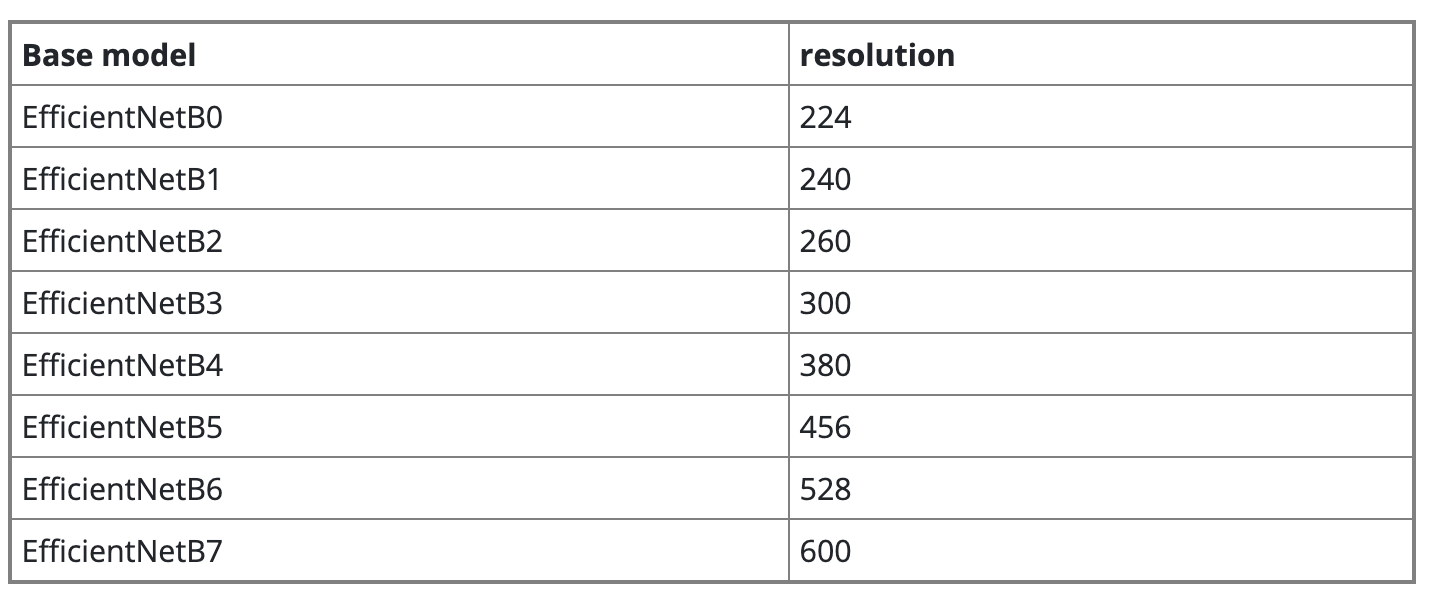

In [ ]:
target_size_dim = 300
batch_size = 32

## Train Valid Split

In [ ]:
df['label'] = df['label'].astype('str') # Since we are using inbuilt generator it takes label as string

X_train, X_valid = train_test_split(df, test_size = 0.1, random_state=SEED, shuffle=True)

In [ ]:
train_gen = make_train_gen(X_train, x_col = 'path', y_col='label', batch_size=batch_size, target_size_dim=target_size_dim)
valid_gen = make_val_gen(X_valid, x_col = 'path', y_col='label', batch_size=batch_size*2, target_size_dim=target_size_dim)

### Visualizing Output of generator

In [ ]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 6, figsize = (32, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x.astype(np.uint8))
    c_ax.set_title(np.argmax(c_y))
    c_ax.axis('off')

In [ ]:
t_x, t_y = next(valid_gen)
fig, m_axs = plt.subplots(4, 6, figsize = (32, 16))
for (c_x,  c_ax) in zip(t_x, m_axs.flatten()):
    c_ax.imshow(c_x.astype(np.uint8))
    c_ax.set_title(np.argmax(c_y))
    c_ax.axis('off')

### Creating Test Generator

In [ ]:
test_gen = make_test_gen(df_test, target_size_dim = target_size_dim, x_col='path', batch_size=batch_size*2)

## Creating Model

In [ ]:
## Only available in tf2.3+

from tensorflow.keras.applications import EfficientNetB3 
from tensorflow.keras.losses import CategoricalCrossentropy

In [ ]:
def load_pretrained_model(weights_path, drop_connect, target_size_dim, layers_to_unfreeze=5):
    model = EfficientNetB3(
            weights=None, 
            include_top=False, 
            input_shape=(target_size_dim, target_size_dim, 3),
            drop_connect_rate=0.4
        )
    
    model.load_weights(weights_path)
    
    model.trainable = True

    # for layer in model.layers[-layers_to_unfreeze:]:
    #     if not isinstance(layer, tf.keras.layers.BatchNormalization): 
    #         layer.trainable = True

    if DEBUG:
        for layer in model.layers:
            print(layer.name, layer.trainable)

    return model

def build_my_model(base_model, optimizer, loss='categorical_crossentropy', metrics = ['categorical_accuracy']):
    
    my_model = Sequential()    
    my_model.add(base_model)
    my_model.add(GlobalAveragePooling2D())
    my_model.add(Dense(256))
    my_model.add(BatchNormalization())
    my_model.add(Activation('relu'))
    my_model.add(Dropout(0.3))
    my_model.add(Dense(5, activation='softmax'))
    my_model.compile(
        optimizer=optimizer,
        loss=CategoricalCrossentropy(label_smoothing=0.05),
        metrics=metrics
    )
    return my_model



In [ ]:
#!wget https://storage.googleapis.com/keras-applications/efficientnetb3_notop.h5
## to get model weights

In [ ]:
model_weights_path = '../input/noisystudent/efficientnetb3_notop.h5'
model_weights_path

In [ ]:
drop_rate = 0.4 ## value of dropout to be used in loaded network
base_model = load_pretrained_model( model_weights_path, drop_rate, target_size_dim )

optimizer = tf.keras.optimizers.Adam(lr = 1e-4)
my_model = build_my_model(base_model, optimizer)
my_model.summary()

### Callbacks

In [ ]:
weight_path_save = 'best_model.hdf5'
last_weight_path = 'last_model.hdf5'

checkpoint = ModelCheckpoint(weight_path_save, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = False)
checkpoint_last = ModelCheckpoint(last_weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=False, 
                             mode= 'min', 
                             save_weights_only = False)


early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.00001)
callbacks_list = [checkpoint, checkpoint_last, early, reduceLROnPlat]

## Train Model

In [ ]:
if DEBUG:
    epochs = 3
else:
    epochs = 20

In [ ]:
# from sklearn.utils import class_weight

# classes_to_predict =[0, 1, 2, 3, 4]
# class_weights = class_weight.compute_class_weight("balanced", classes_to_predict, train_gen.labels)
# class_weights_dict = {i : class_weights[i] for i,label in enumerate(classes_to_predict)}

# print(class_weights_dict)


In [ ]:
if DEBUG:
    history = my_model.fit(train_gen, 
                          validation_data = valid_gen, 
                          epochs = epochs, 
                          callbacks = callbacks_list,
                           steps_per_epoch=1
                           #class_weight=class_weights_dict
                          )
else:
    history = my_model.fit(train_gen, 
                          validation_data = valid_gen, 
                          epochs = epochs, 
                          callbacks = callbacks_list,
                           #class_weight=class_weights_dict
                          )

In [ ]:
def plot_hist(hist):
    plt.figure(figsize=(15,5))
    plt.plot(np.arange(epochs), hist.history["categorical_accuracy"], '-o', label='Train Accuracy',color='#ff7f0e')
    plt.plot(np.arange(epochs), hist.history["val_categorical_accuracy"], '-o',label='Val Accuracy',color='#1f77b4')
    plt.xlabel('Epoch',size=14)
    plt.ylabel('Accuracy',size=14)
    plt.legend(loc=2)
    
    plt2 = plt.gca().twinx()
    plt2.plot(np.arange(epochs) ,history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
    plt2.plot(np.arange(epochs) ,history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
    plt.legend(loc=3)
    plt.ylabel('Loss',size=14)
    plt.title("Model Accuracy and loss")
    
    #plt.legend(["train", "validation"], loc="upper left")
    
    plt.savefig('loss.png')
    plt.show()


In [ ]:
plot_hist(history)

## Evaluating Model on Validation Set

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
my_model.load_weights(weight_path_save) ## load the best model or all your metrics would be on the last run not on the best one

In [ ]:
pred_valid_y = my_model.predict(valid_gen,  verbose = True)
pred_valid_y_labels = np.argmax(pred_valid_y, axis=-1)
valid_labels=valid_gen.labels

print(classification_report(valid_labels, pred_valid_y_labels ))

In [ ]:
print(confusion_matrix(valid_labels, pred_valid_y_labels ))

## Getting Predictions on Test Set

In [ ]:
pred_test = my_model.predict(test_gen, verbose = True)
pred_test_labels = np.argmax(pred_test, axis = -1)

## Creating Submission File

In [ ]:
final_submission = df_test

final_submission['image_id'] = final_submission.path.str.split('/').str[-1]
final_submission['label'] = pred_test_labels

final_csv = final_submission[['image_id', 'label']]
final_csv.head()



In [ ]:
final_csv.to_csv('submission.csv', index=False)


**Work In Progress. I am thinking on why the validation loss is fluctuating. This indicates me to the fact that the dataset is too noisy. Will surely work on some other approach for this noisy dataset. If you learnt something from this kernel kindly upvote :)**

## Inference kernel is [here](https://www.kaggle.com/harveenchadha/efficientnetb3-baseline-inference-keras-tf2)